<a href="https://colab.research.google.com/github/JoYBoy7214/emotion_and_action_recognition/blob/main/action1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d meetnagadia/human-action-recognition-har-dataset

Dataset URL: https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset
License(s): ODbL-1.0
 76% 226M/297M [00:00<00:00, 669MB/s] 
100% 297M/297M [00:00<00:00, 604MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/human-action-recognition-har-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

target_classes = ['sitting', 'sleeping', 'texting']

# Load and filter training labels
train_df = pd.read_csv('/content/HumanActionRecognition/Training_set.csv')
train_df = train_df[train_df['label'].isin(target_classes)]

# Construct full image path
train_df['file_path'] = '/content/HumanActionRecognition/train/' + train_df['filename']

# Map labels to integers
label_map = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}
train_df['label_idx'] = train_df['label'].map(label_map)




In [ ]:
train_split, val_split = train_test_split(train_df, test_size=0.2, stratify=train_df['label_idx'], random_state=42)

label
sleeping    672
texting     672
sitting     672
Name: count, dtype: int64
label_idx
1    672
2    672
0    672
Name: count, dtype: int64


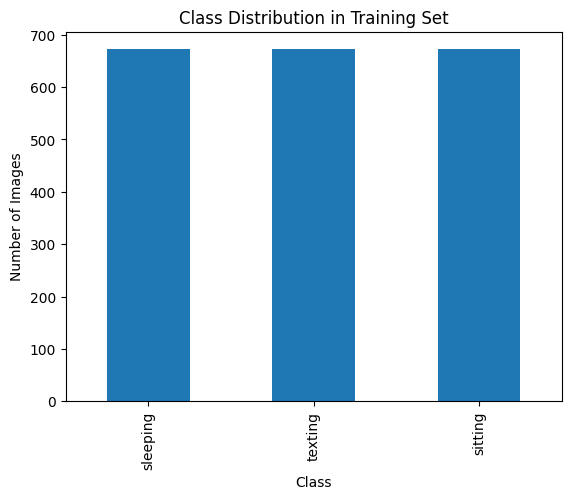

In [ ]:
import matplotlib.pyplot as plt
# If using class names
print(train_split['label'].value_counts())

# If using numeric labels (e.g., after LabelEncoder)
print(train_split['label_idx'].value_counts())

train_split['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.05),
])

# Create dataset from dataframe
def create_tf_dataset(df, img_size=(224, 224), batch_size=32, shuffle=True, augment=False):
    def load_img(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        if augment:
            img = data_augmentation(img)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, label

    paths = df['file_path'].values
    labels = df['label_idx'].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_img, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(batch_size).prefetch(AUTOTUNE)

# Train/val datasets
train_ds = create_tf_dataset(train_split, batch_size=BATCH_SIZE, augment=True)
val_ds = create_tf_dataset(val_split, batch_size=BATCH_SIZE, shuffle=False, augment=False)

# Load base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Define model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Initial training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

# Fine-tune the model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Unfreeze top 30 layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning training
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.5773 - loss: 0.9570 - val_accuracy: 0.8254 - val_loss: 0.4828
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8034 - loss: 0.5065 - val_accuracy: 0.8413 - val_loss: 0.4450
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8192 - loss: 0.4382 - val_accuracy: 0.8393 - val_loss: 0.4428
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8414 - loss: 0.4068 - val_accuracy: 0.8472 - val_loss: 0.4299
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8613 - loss: 0.3736 - val_accuracy: 0.8373 - val_loss: 0.4411
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8602 - loss: 0.3542 - val_accuracy: 0.8452 - val_loss: 0.4166
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8740 - loss: 0.3606 - val_accuracy: 0.8452 - val_loss: 0.4082
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/action_model1.keras')

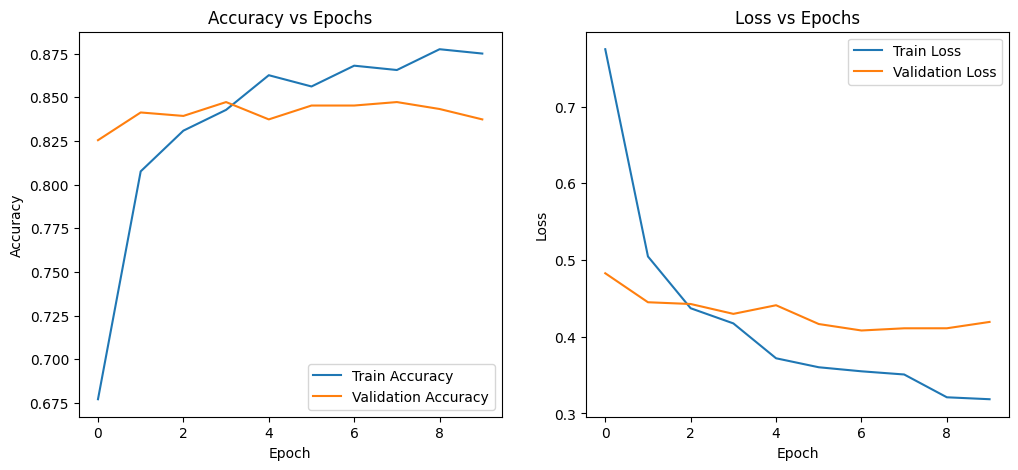

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


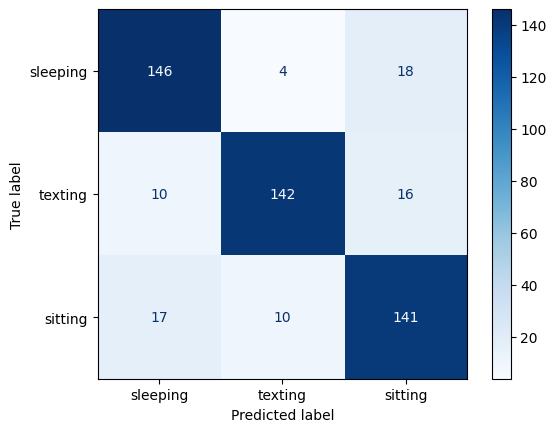

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions from validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['sleeping', 'texting','sitting'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
